In [61]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

Funcion llamada API

In [37]:
RATE_LIMIT =  600 # Número máximo de solicitudes por minuto
COOL_OFF_PERIOD = 60  # Tiempo de espera en segundos si se alcanza el límite de velocidad

# Variables para hacer un seguimiento del tiempo de las solicitudes
last_request_time = 0
request_count = 0
def call_api(url, params):
    global last_request_time, request_count
    
    # Calcular el tiempo transcurrido desde la última solicitud
    elapsed_time = time.time() - last_request_time
    
    # Si ha pasado menos de un minuto desde la última solicitud y hemos alcanzado el límite de velocidad,
    # esperamos el tiempo de enfriamiento antes de hacer la siguiente solicitud
    if elapsed_time < 60 and request_count >= RATE_LIMIT:
        print("Se ha alcanzado el límite de velocidad. Esperando...")
        time.sleep(COOL_OFF_PERIOD)
        last_request_time = time.time()
        request_count = 0
    
    try:
        response = requests.get(url, params)
        response.raise_for_status()  # Lanza una excepción en caso de error HTTP
        last_request_time = time.time()
        request_count += 1
        return response.json()
    except requests.exceptions.RequestException as e:
        print("Error al hacer la solicitud a la API:", e)
        return None

Funcion para conseguir la data metereologica de una ciudad

In [99]:

def get_data_meteo_api(city):
    locations = {
        "Madrid": {"latitud": 40.4165, "longitud": -3.7026},
        "London": {"latitud": 51.507351, "longitud": -0.127758},
        "Rio": {"latitud": -22.906847, "longitud": -43.172896}
    }
    if city not in locations:
        print("Ciudad no válida")
        return None
    
    params = {
    "latitude": locations[city]["latitud"],
    "longitude": locations[city]["longitud"],
    "start_date": "1950-01-01",
    "end_date": "2050-01-01",
    "models": ["CMCC_CM2_VHR4", "FGOALS_f3_H", "HiRAM_SIT_HR", "MRI_AGCM3_2_S", "EC_Earth3P_HR", "MPI_ESM1_2_XR", "NICAM16_8S"],
    "daily": "temperature_2m_mean,precipitation_sum,soil_moisture_0_to_10cm_mean"
    }
    URL="https://climate-api.open-meteo.com/v1/climate"
    data=call_api(URL, params)
    return data


In [39]:
data_json=get_data_meteo_api("Madrid")


In [66]:
df=pd.DataFrame(data_json['daily'])

Funcion para eliminar las variables con mayor de un 5% de NA o NAN

In [98]:
def eliminar_variables_faltantes(df, umbral=5):
    """
    Verifica si hay variables en un DataFrame que tienen más del 'umbral'% de valores faltantes (NA o NaN) y las elimina.
    
    Parámetros:
        - df: DataFrame, el DataFrame que se va a verificar y modificar.
        - umbral: int, el umbral en porcentaje para considerar si una variable se elimina o no (por defecto es 5).
        
    Devuelve:
        - DataFrame, el DataFrame resultante después de eliminar las variables con valores faltantes por encima del umbral.
    """
    # Calcular el porcentaje de valores faltantes para cada variable
    porcentaje_faltantes = df.isna().mean() * 100

    # Filtrar las variables que tienen más del umbral% de valores faltantes
    variables_a_eliminar = porcentaje_faltantes[porcentaje_faltantes > umbral].index

    # Eliminar las variables del DataFrame
    df_sin_variables_faltantes = df.drop(columns=variables_a_eliminar)



    return df_sin_variables_faltantes

In [ ]:
df_limpio=eliminar_variables_faltantes(df)

Funcion para calcular la media anual y pasar los datos diarios a anuales

In [82]:
def media_anual(df):
    """
    Pasa de datos diarios/semanales/mensuales a datos anuales
    
    Parámetros:
        - df: DataFrame con la primera columna time.
        
    Devuelve:
        - DataFrame, el DataFrame con datos anualizados de su media
    """
    # Convertir la columna 'time' a tipo datetime
    df['time'] = pd.to_datetime(df['time'])

    # Extraer el año de la columna 'time'
    df['year'] = df['time'].dt.year

    # Calcular la media anual de cada variable climatológica
    df_anual = df.groupby('year').mean()
    df_anual = df_anual.set_index('time')
    

    
    return df_anual




In [83]:
df_anual=media_anual(df_limpio)

Funcion para calcular la desviacion tipica anual y pasar los datos diarios a anuales

In [85]:
def std_anual(df):
    """
    Pasa de datos diarios/semanales/mensuales a datos anuales
    
    Parámetros:
        - df: DataFrame con la primera columna time.
        
    Devuelve:
        - DataFrame, el DataFrame con datos anualizados de la desviacion tipica
    """
    # Convertir la columna 'time' a tipo datetime
    df['time'] = pd.to_datetime(df['time'])

    # Extraer el año de la columna 'time'
    df['year'] = df['time'].dt.year

    # Calcular la desviacion tipica de cada variable climatológica
    df_anual = df.groupby('year').std()
    df_anual = df_anual.set_index('time')

    
    return df_anual

In [86]:
df_std=std_anual(df_limpio)

Funcion para hacer un plot de una serie temporal

In [90]:
def plotear_temporal(df, columna=1):

    plt.figure(figsize=(10, 6))
    plt.plot(df_anual.index, df_anual.iloc[:,columna], marker='o', linestyle='-')
    plt.title('Media anual de ' + df_anual.columns[columna])
    plt.xlabel('Año')
    plt.ylabel('Media')
    plt.grid(True)
    plt.show()

Funcion que plotea todas las variables.

In [92]:
def plotear_temporal_todas(df):
    for i in range(len(df.columns)):
        plotear_temporal(df,i)

In [ ]:
plotear_temporal_todas(df_anual)

In [94]:
def modulo1(lista_paises):
    for pais in lista_paises:
        data_json=get_data_meteo_api(pais)
        df=pd.DataFrame(data_json['daily'])
        df_limpio=eliminar_variables_faltantes(df)
        df_anual=media_anual(df_limpio)
        df_std=std_anual(df_limpio)
        plotear_temporal_todas(df_anual)
        plotear_temporal_todas(df_std)
        

Se han eliminado las siguientes variables con más del 5% de valores faltantes:
Index(['soil_moisture_0_to_10cm_mean_CMCC_CM2_VHR4',
       'soil_moisture_0_to_10cm_mean_FGOALS_f3_H',
       'soil_moisture_0_to_10cm_mean_HiRAM_SIT_HR',
       'soil_moisture_0_to_10cm_mean_MPI_ESM1_2_XR',
       'soil_moisture_0_to_10cm_mean_NICAM16_8S'],
      dtype='object')


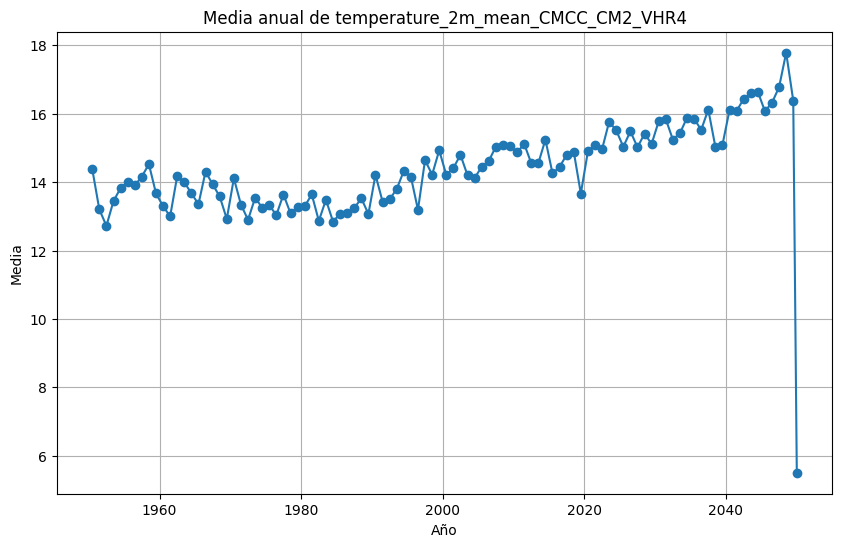

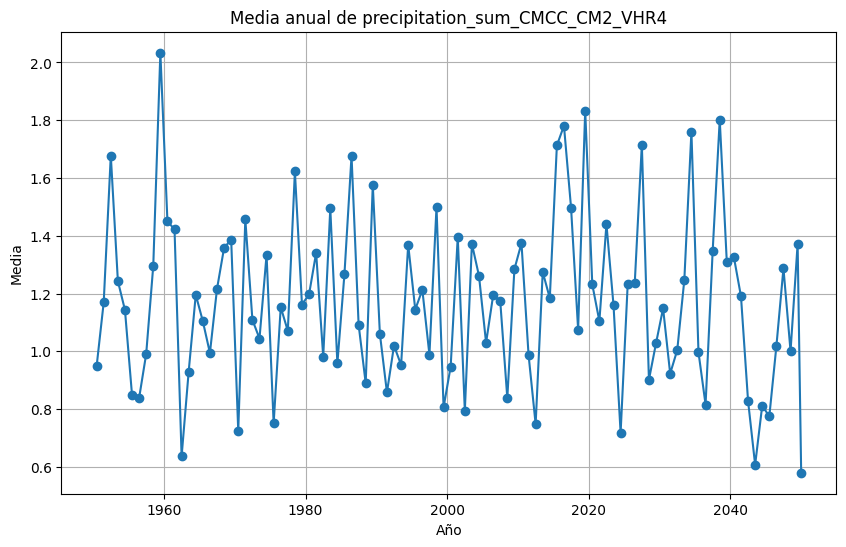

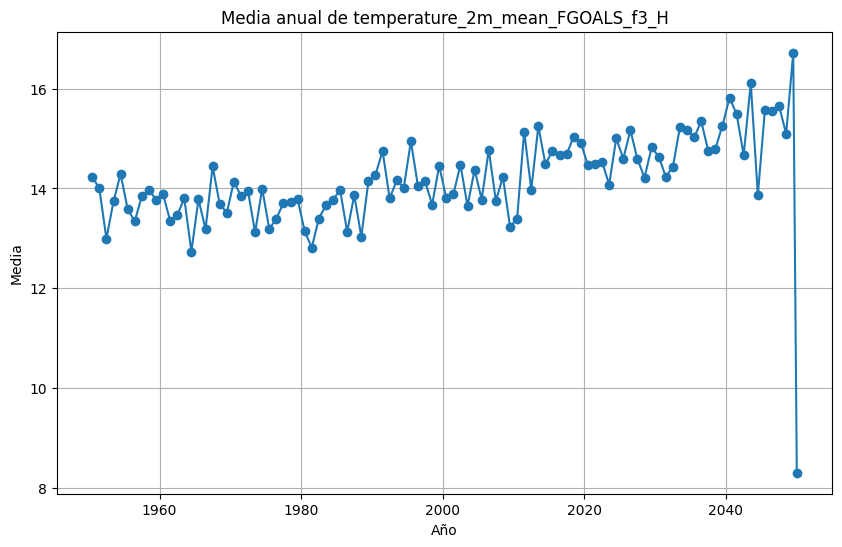

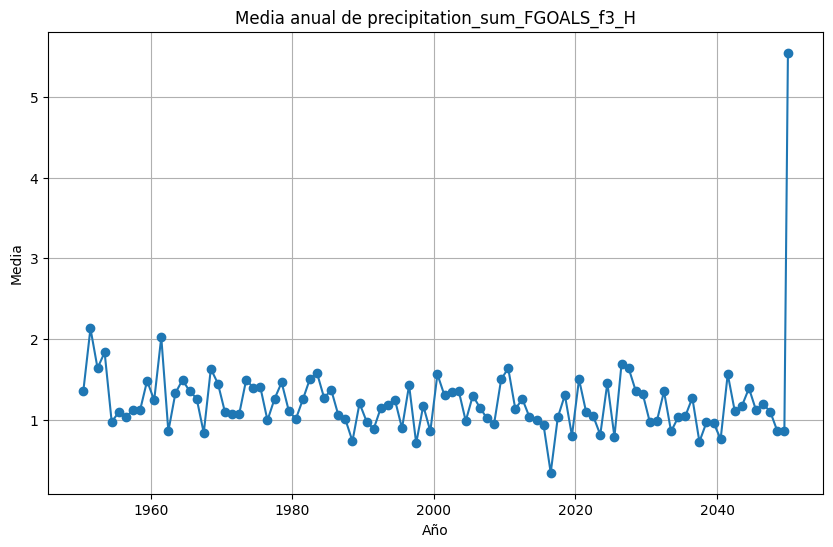

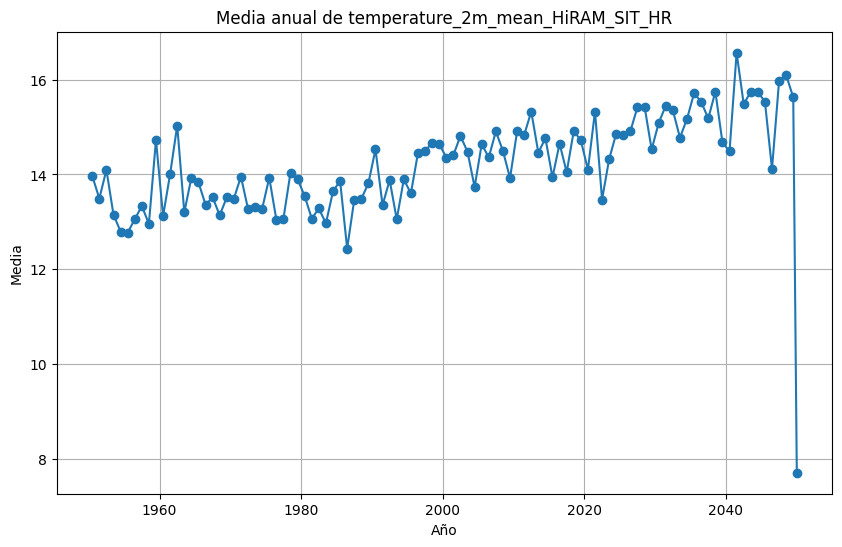

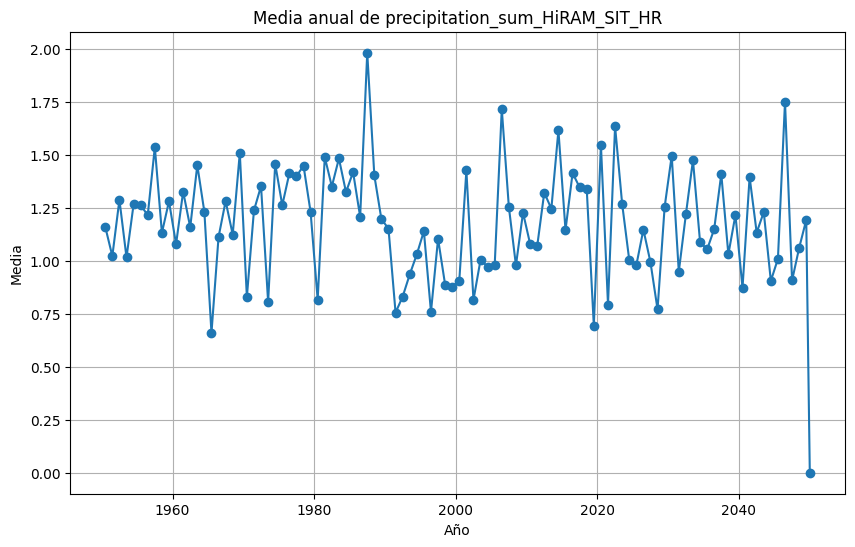

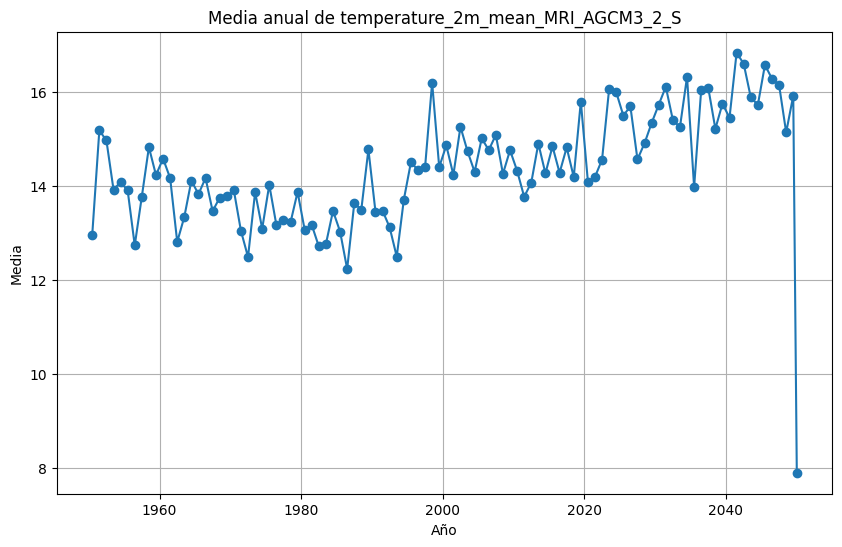

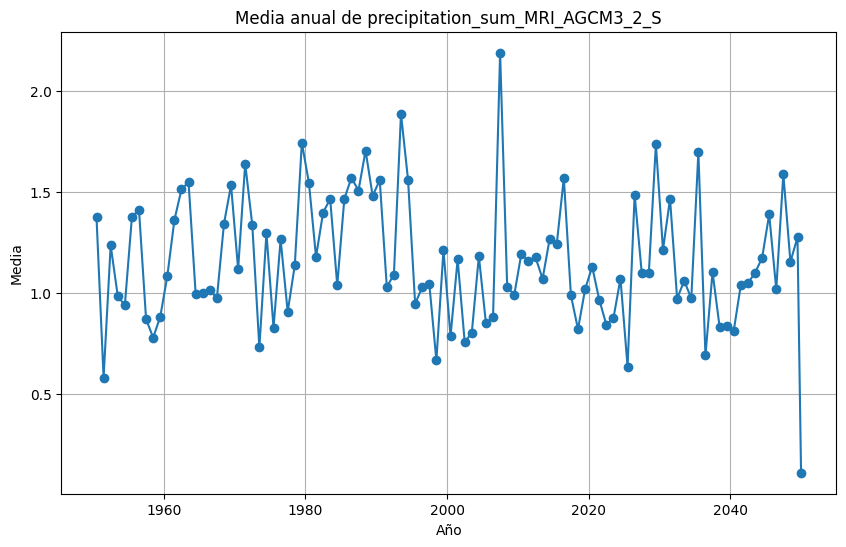

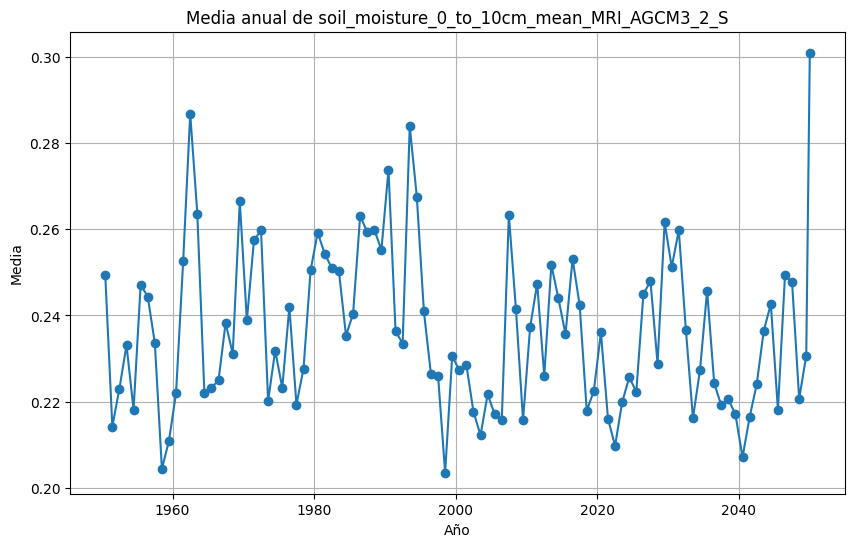

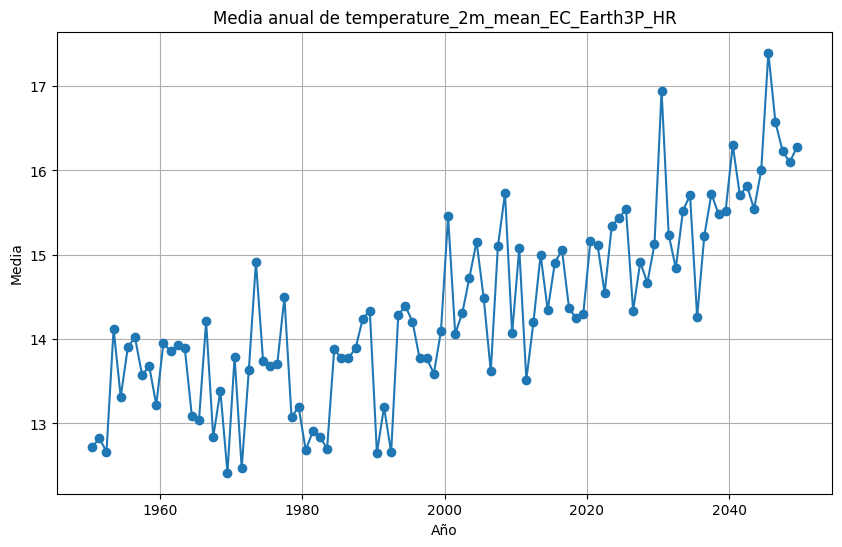

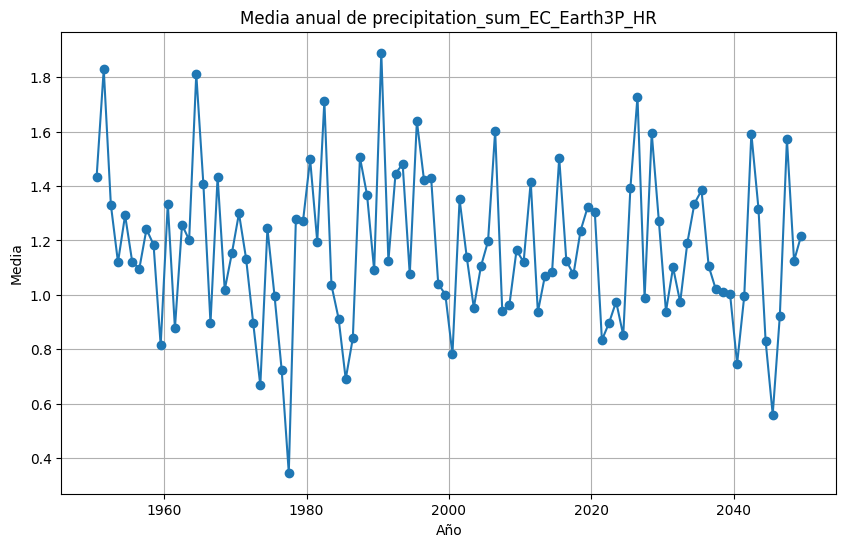

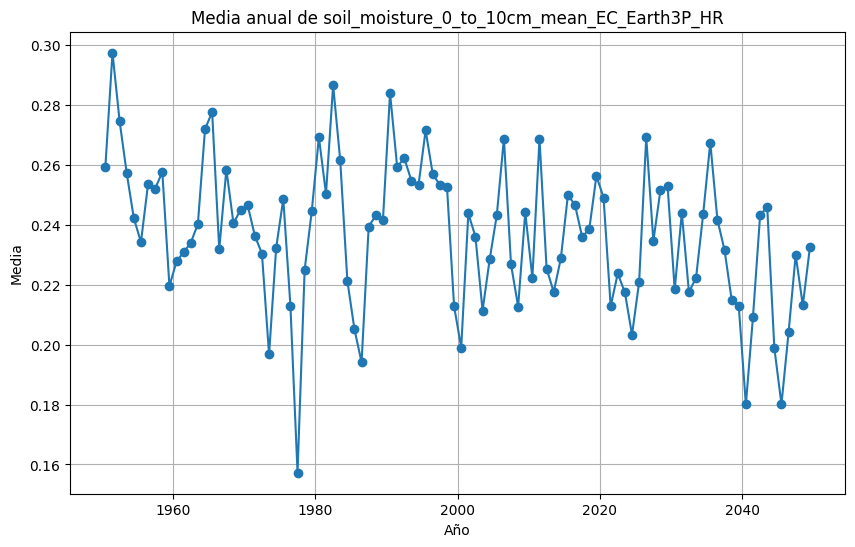

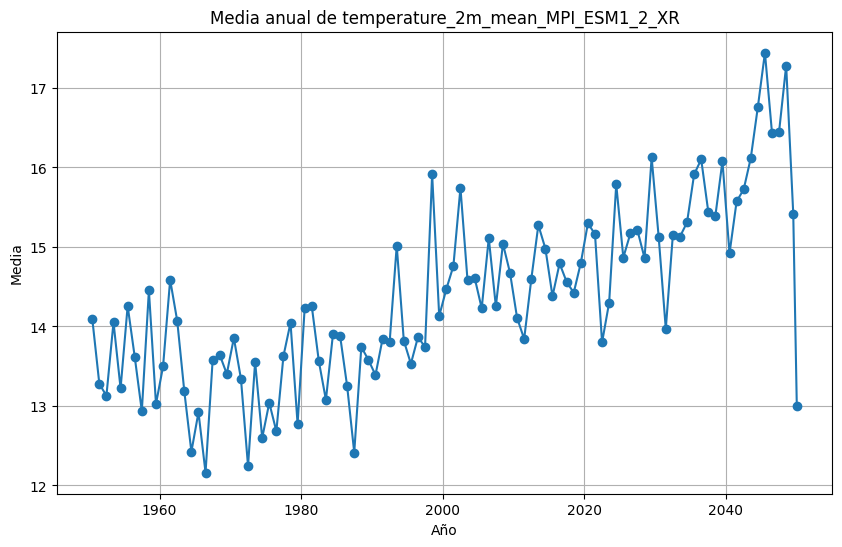

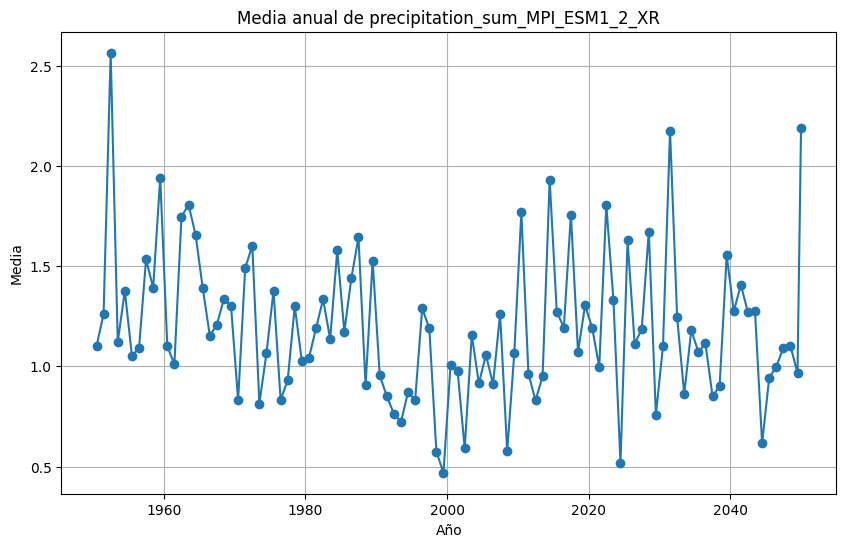

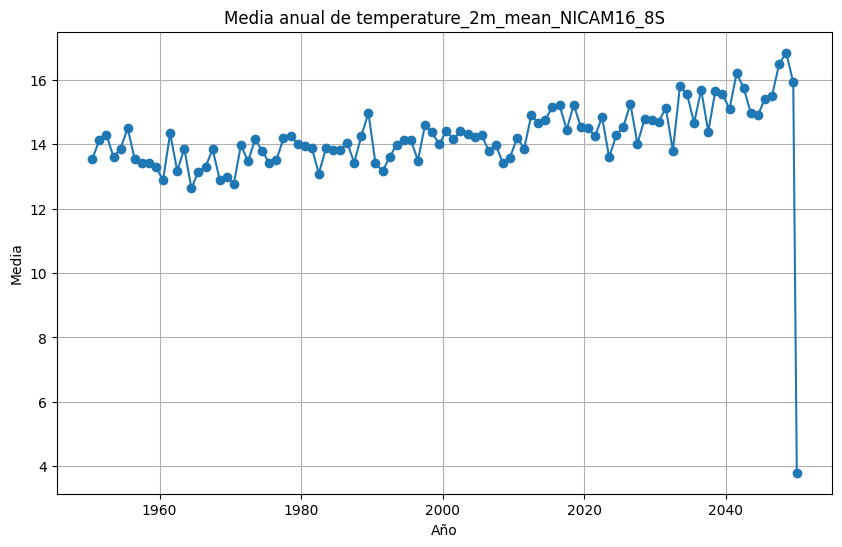

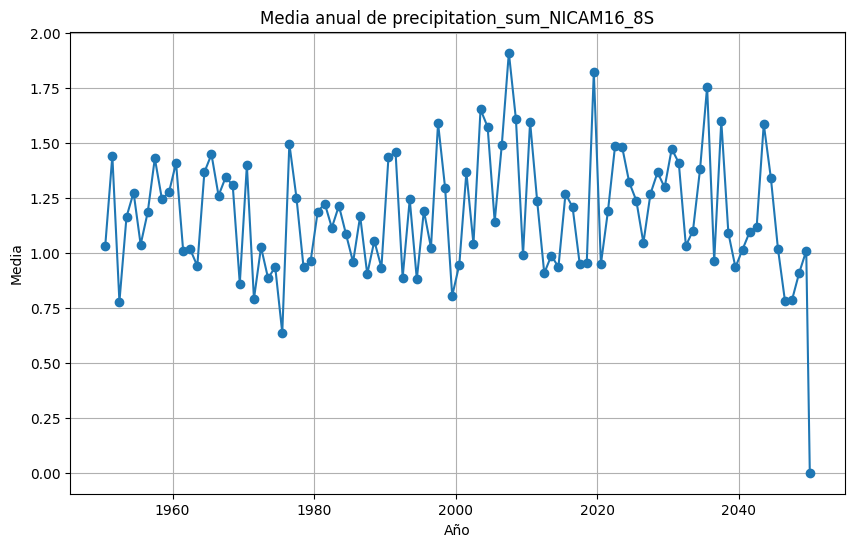

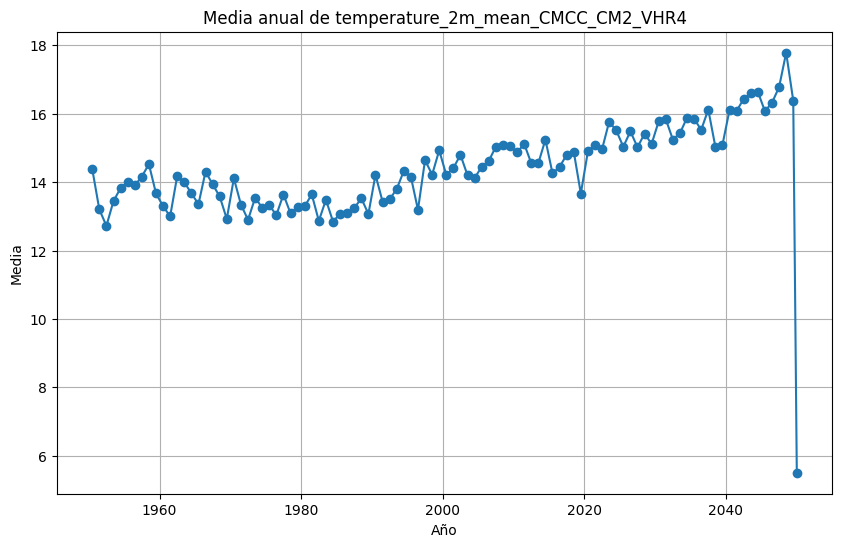

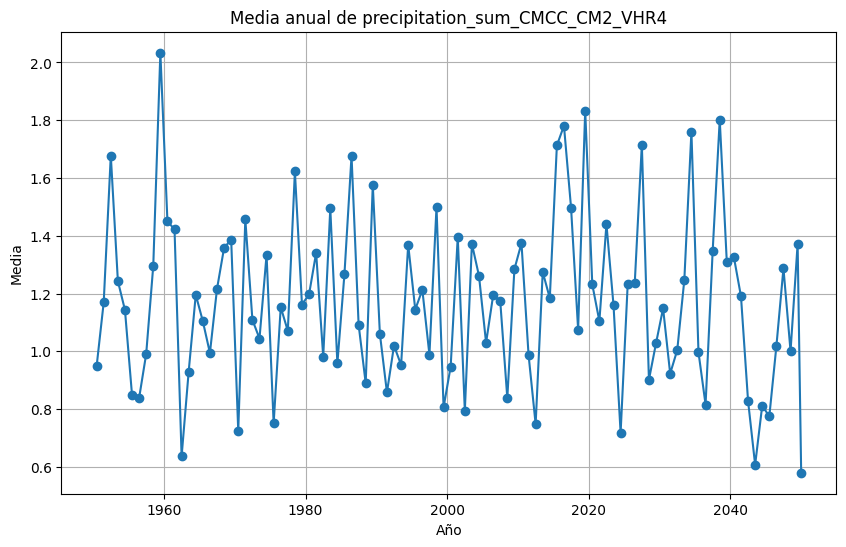

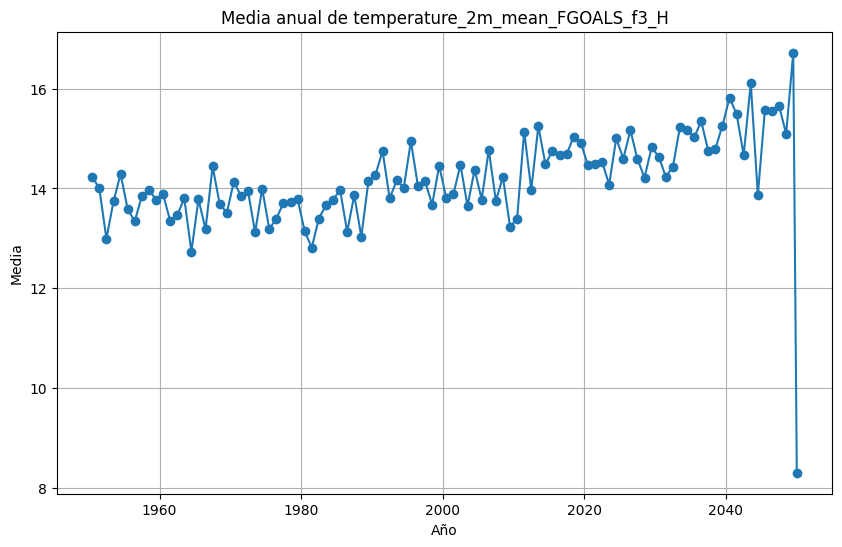

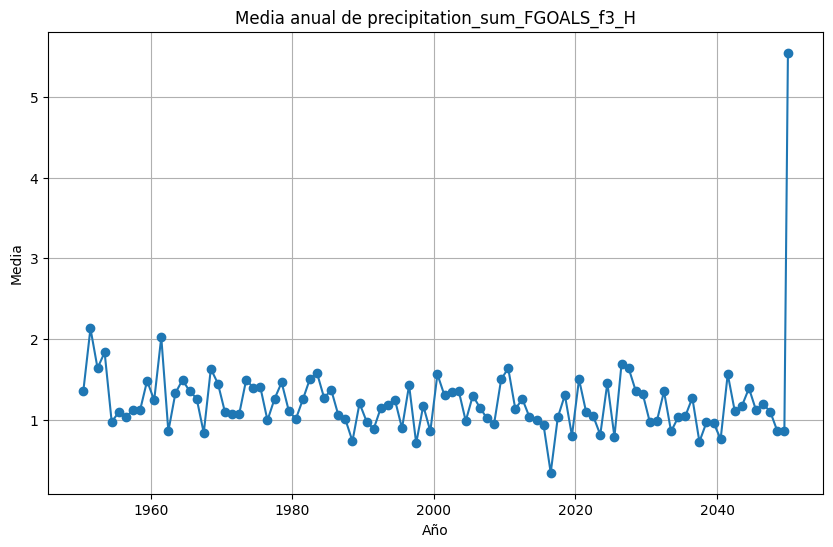

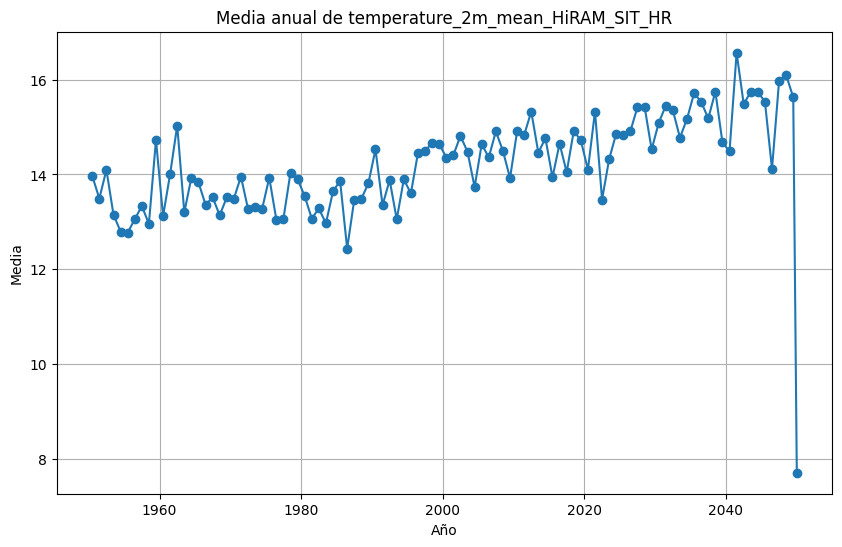

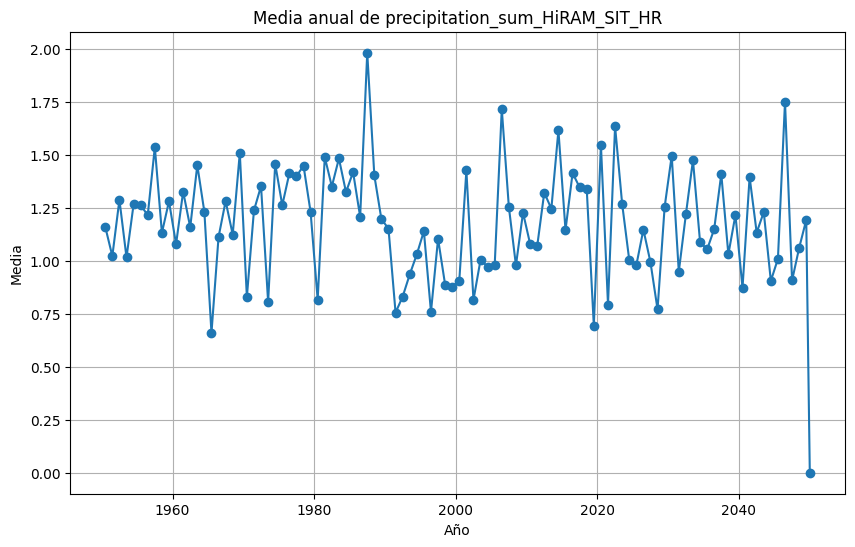

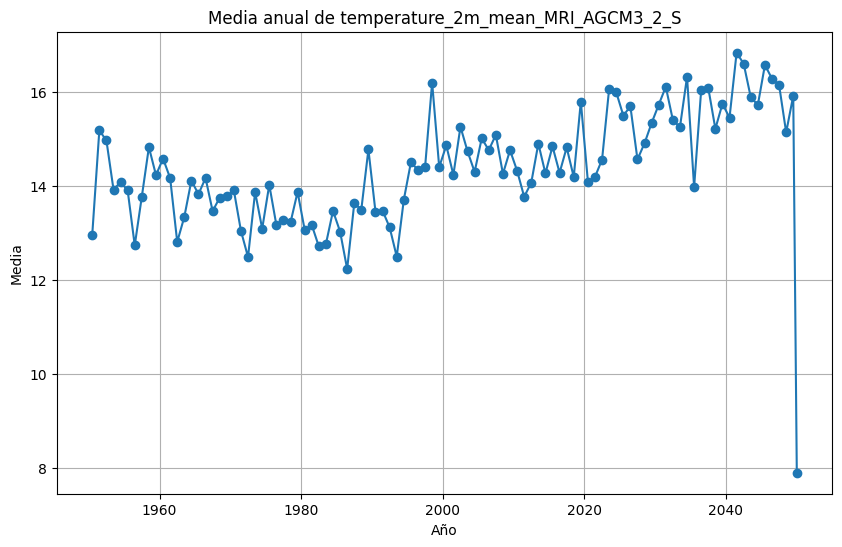

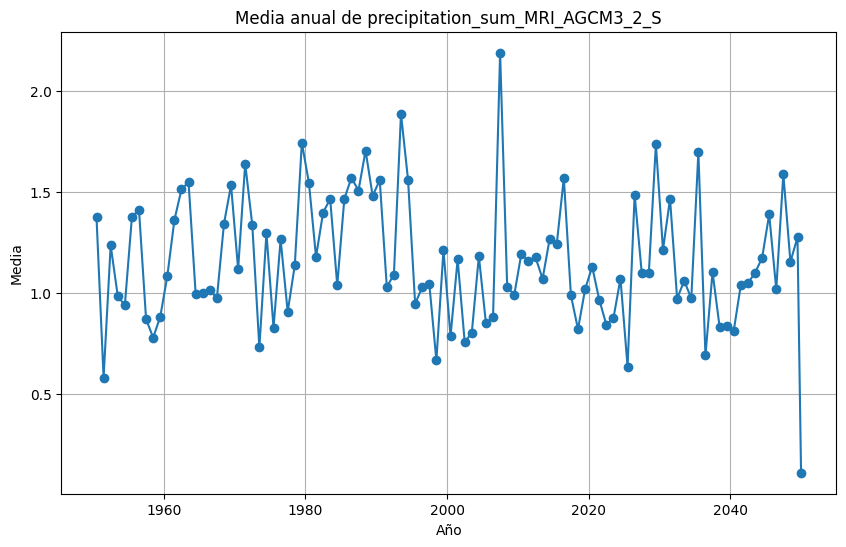

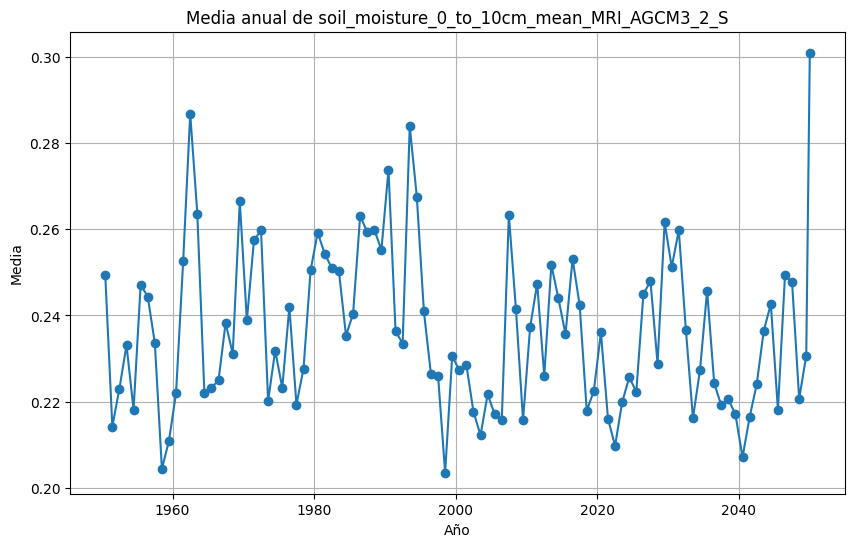

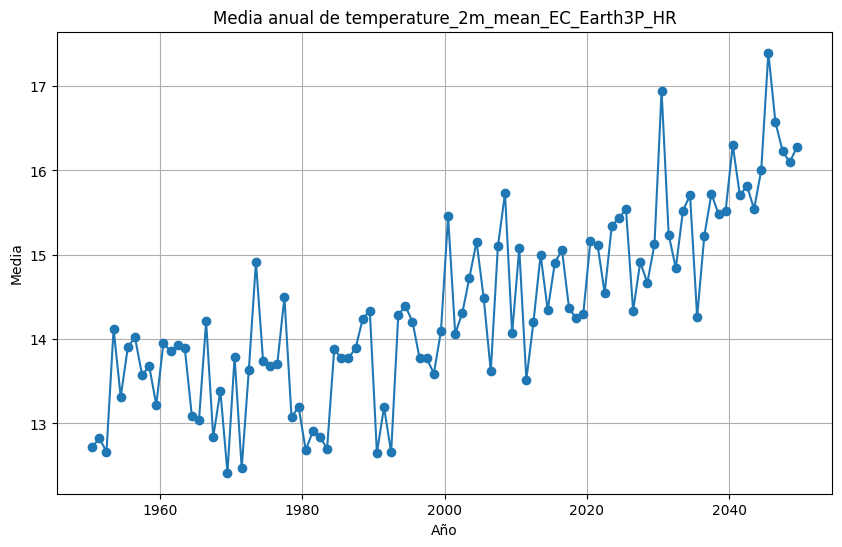

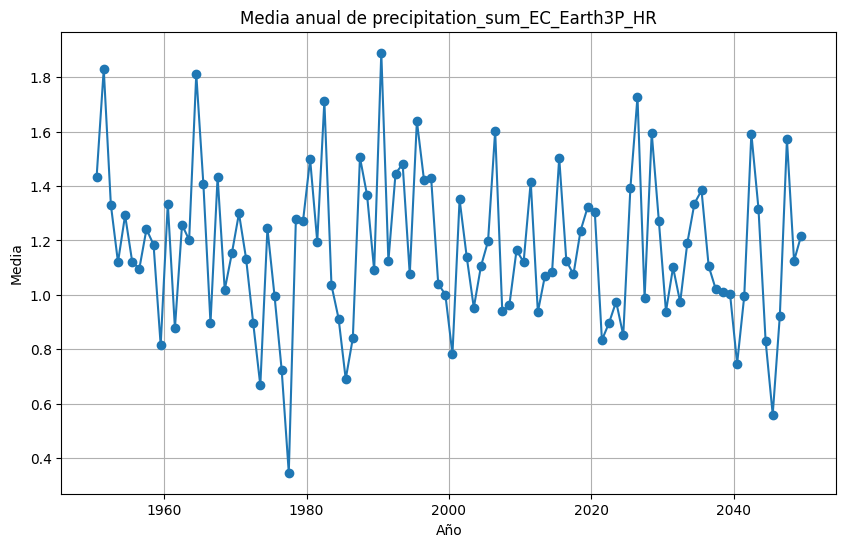

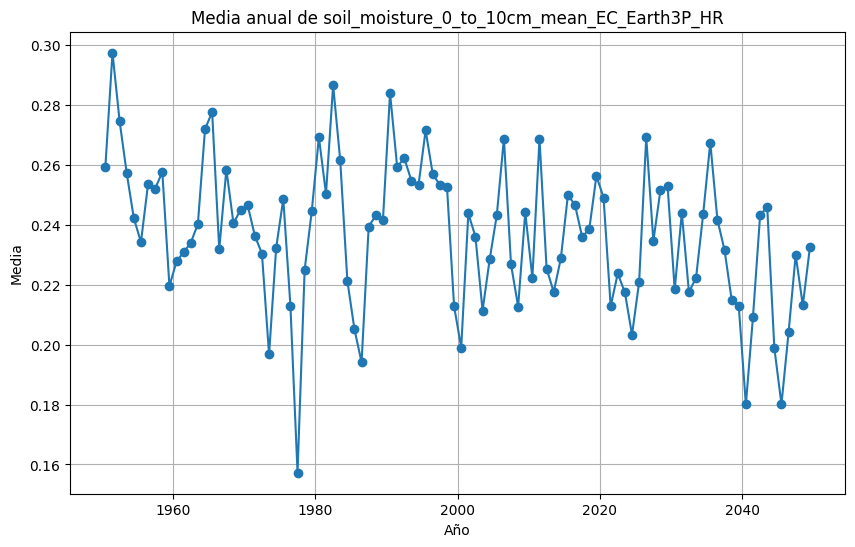

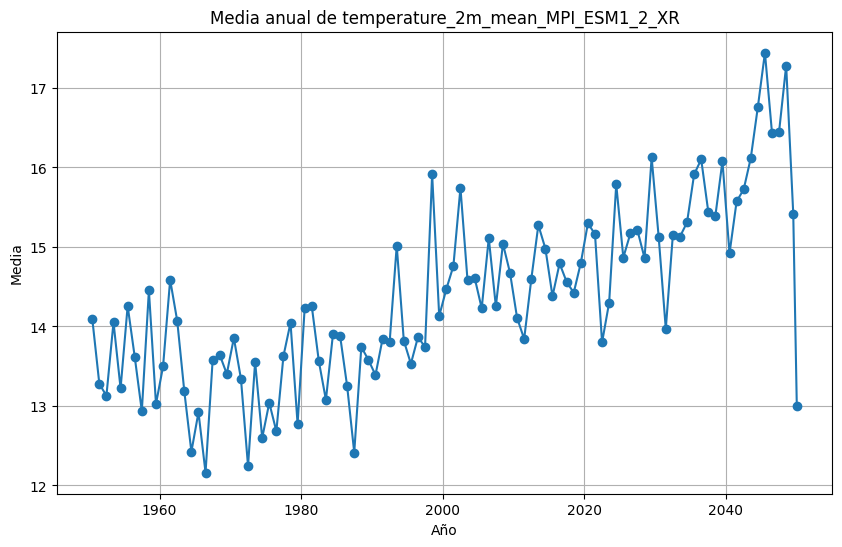

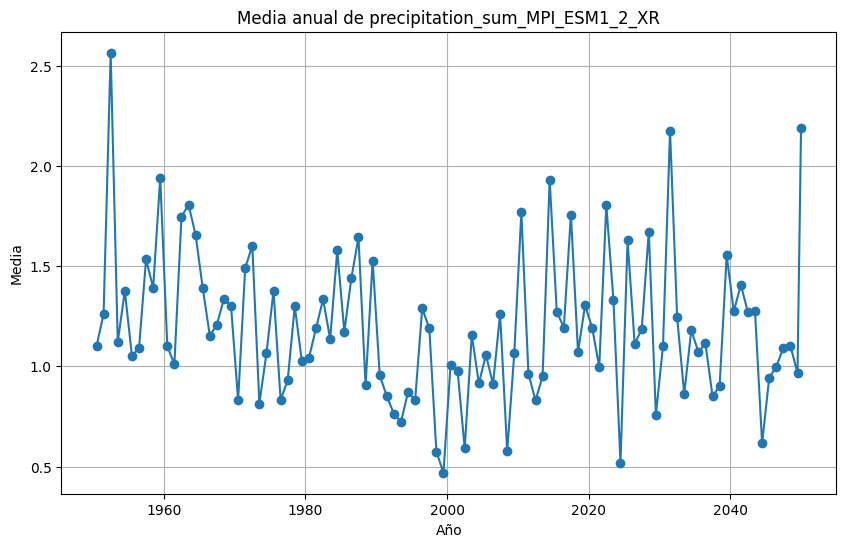

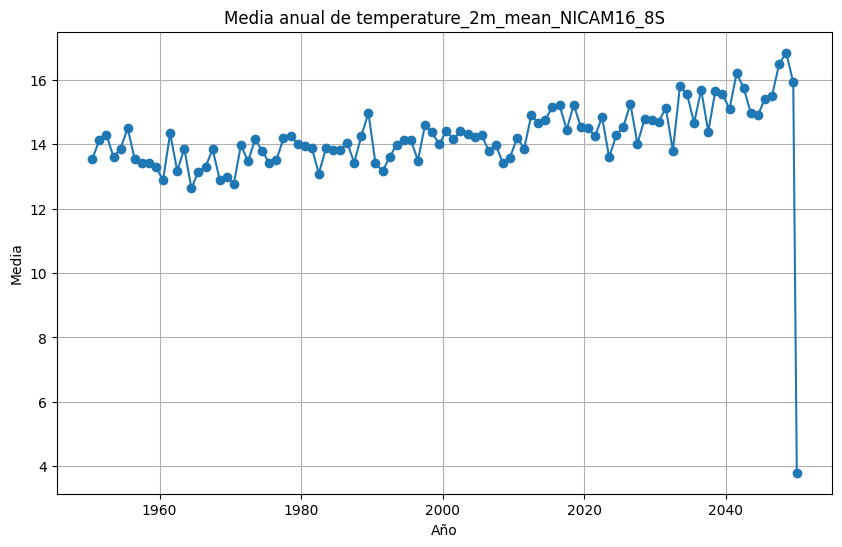

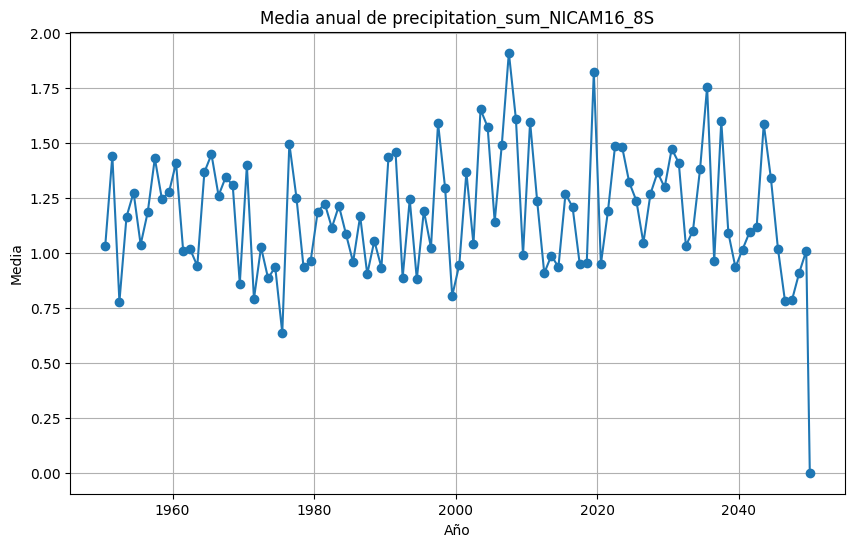

Error al hacer la solicitud a la API: 429 Client Error: Too Many Requests for url: https://climate-api.open-meteo.com/v1/climate?latitude=51.507351&longitude=-0.127758&start_date=1950-01-01&end_date=2050-01-01&models=CMCC_CM2_VHR4&models=FGOALS_f3_H&models=HiRAM_SIT_HR&models=MRI_AGCM3_2_S&models=EC_Earth3P_HR&models=MPI_ESM1_2_XR&models=NICAM16_8S&daily=temperature_2m_mean%2Cprecipitation_sum%2Csoil_moisture_0_to_10cm_mean


TypeError: 'NoneType' object is not subscriptable

In [97]:
lista_paises=["Madrid", "London", "Rio"]
modulo1(lista_paises)